# OWL-ViT

This Colab shows how to **load a pre-trained OWL-ViT checkpoint** and use it to
**get object detection predictions** for an image.

# Set up the model
OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [7]:
import os
import sys
sys.path.append('/big_vision/')
import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import configs
from scenic.projects.owl_vit import models
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform
from skimage import data as skimage_data


config = configs.owl_v2_clip_b16.get_config(init_mode='canonical_checkpoint')

module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    objectness_head_configs=config.model.objectness_head,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

variables = module.load_variables(config.init_from.checkpoint_path)

# Prepare image

In [8]:
# Load example image:
image_uint8 = skimage_data.astronaut()
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# Text-conditioned detection

### Prepare text queries

In [9]:
text_queries = ['face', 'rocket', 'nasa badge', 'star-spangled banner']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)

100%|█████████████████████████████████████| 1.29M/1.29M [00:00<00:00, 3.35MiB/s]


### Get predictions
This will take a minute on the first execution due to model compilation. Subsequent executions will be faster.

In [10]:
jitted = jax.jit(module.apply, static_argnames=('train',))

In [11]:
# Note: The model expects a batch dimension.
predictions = jitted(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

### Plot predictions

In [12]:
%matplotlib inline

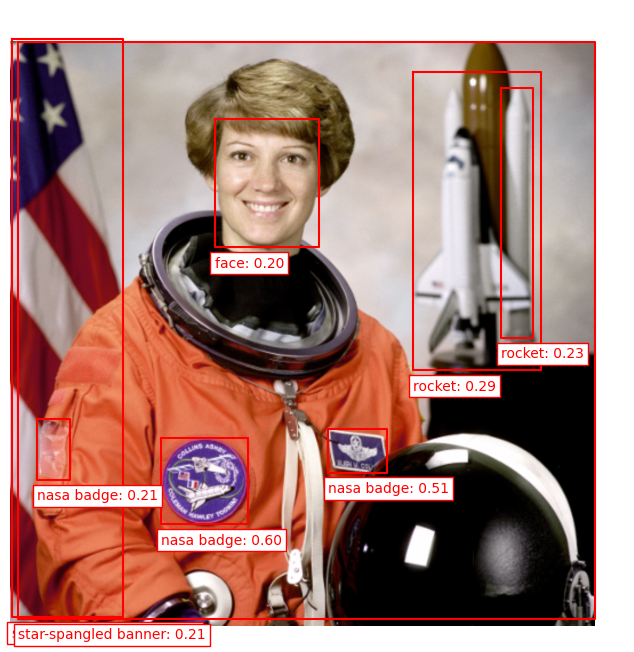

In [13]:
score_threshold = 0.2

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue
  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha='left',
      va='top',
      color='red',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'red',
          'boxstyle': 'square,pad=.3'
      })

## Plot objectness

Text(0.5, 1.0, 'Top 20 objects by objectness')

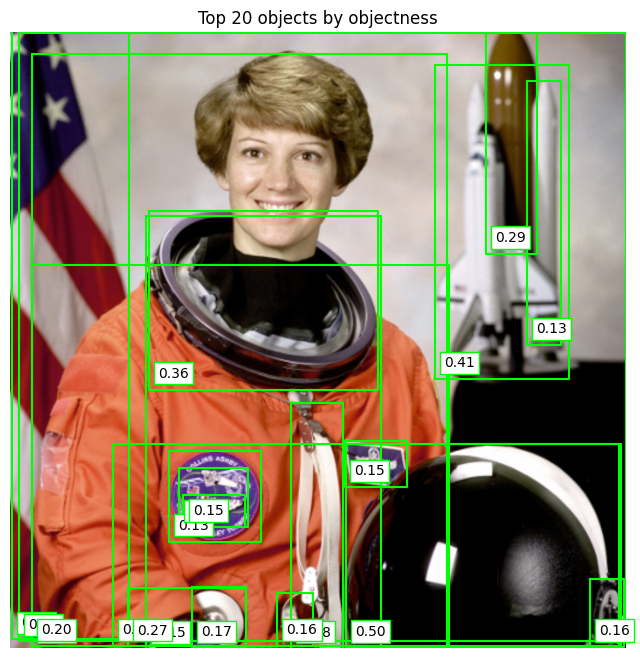

In [16]:
top_k = 20
objectnesses = sigmoid(predictions['objectness_logits'])
boxes = predictions['pred_boxes']

objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for box, objectness in zip(boxes, objectnesses):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
          color='lime')

  ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    f'{objectness:1.2f}',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3'
    })

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')

# Image-conditioned detection
This section shows how to use objects detected in one image as queries on other images, instead of text strings.

## Prepare images
* The query object will be taken from `source_image`.
* Then, similar objects will be detected in `target_imge`.

In [17]:
def prepare_image(image_uint8):
  # Load example image:
  image = image_uint8.astype(np.float32) / 255.0

  # Pad to square with gray pixels on bottom and right:
  h, w, _ = image.shape
  size = max(h, w)
  image_padded = np.pad(
      image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5
  )

  # Resize to model input size:
  return skimage.transform.resize(
      image_padded,
      (config.dataset_configs.input_size, config.dataset_configs.input_size),
      anti_aliasing=True,
  )

source_image = prepare_image(skimage_data.rocket())
target_image = prepare_image(skimage_data.astronaut())

## Functions to call model components separately

In [19]:
import functools

image_embedder = jax.jit(
    functools.partial(
        module.apply, variables, train=False, method=module.image_embedder
    )
)

objectness_predictor = jax.jit(
    functools.partial(
        module.apply, variables, method=module.objectness_predictor
    )
)

box_predictor = jax.jit(
    functools.partial(module.apply, variables, method=module.box_predictor)
)

class_predictor = jax.jit(
    functools.partial(module.apply, variables, method=module.class_predictor)
)

## Identify an object in the source image to use as query, and get its embedding

Here, we show the top 3 predictions on the source image so that the user can select one to use as a query (we select the rocket here).

To get a query embedding, it is necessary to use a box predicted by the model. We cannot directly embed a whole image.

Text(0.5, 1.0, 'Top 3 objects by objectness')

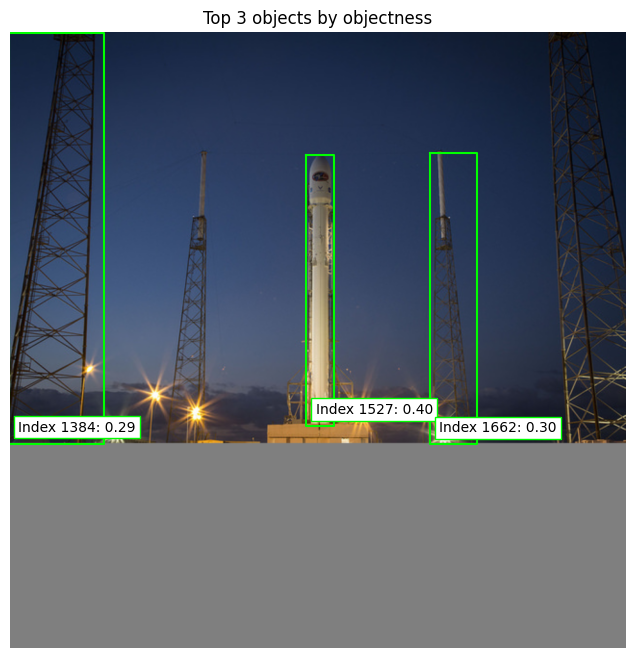

In [20]:
# Embedd images and get boxes, without text queries:
feature_map = image_embedder(source_image[None, ...])

b, h, w, d = feature_map.shape
image_features = feature_map.reshape(b, h * w, d)

objectnesses = objectness_predictor(image_features)['objectness_logits']

source_boxes = box_predictor(
    image_features=image_features, feature_map=feature_map
)['pred_boxes']

source_class_embeddings = class_predictor(image_features=image_features)[
    'class_embeddings'
]

# Remove batch dimension
objectnesses = np.array(objectnesses[0])
source_boxes = np.array(source_boxes[0])
source_class_embeddings = np.array(source_class_embeddings[0])

top_k = 3
objectnesses = sigmoid(objectnesses)
objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(source_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for i, (box, objectness) in enumerate(zip(source_boxes, objectnesses)):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot(
      [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
      [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
      color='lime',
  )

  ax.text(
      cx - w / 2 + 0.015,
      cy + h / 2 - 0.015,
      f'Index {i}: {objectness:1.2f}',
      ha='left',
      va='bottom',
      color='black',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'lime',
          'boxstyle': 'square,pad=.3',
      },
  )

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')

In [21]:
# Get the query embedding with the index of the selected object.
# We're using the rocket:
query_object_index = 1527  # Index of the rocket box above.
query_embedding = source_class_embeddings[query_object_index]

## Get predictions for target image with the query embedding

Text(0.5, 1.0, 'Closest match')

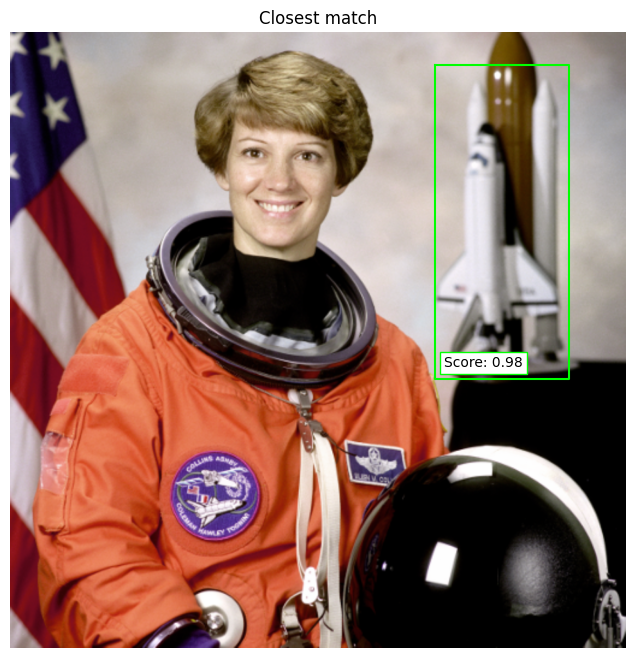

In [22]:
feature_map = image_embedder(target_image[None, ...])

b, h, w, d = feature_map.shape
target_boxes = box_predictor(
    image_features=feature_map.reshape(b, h * w, d), feature_map=feature_map
)['pred_boxes']

target_class_predictions = class_predictor(
    image_features=feature_map.reshape(b, h * w, d),
    query_embeddings=query_embedding[None, None, ...],  # [batch, queries, d]
)


# Remove batch dimension and convert to numpy:
target_boxes = np.array(target_boxes[0])
target_logits = np.array(target_class_predictions['pred_logits'][0])

top_ind = np.argmax(target_logits[:, 0], axis=0)
score = sigmoid(target_logits[top_ind, 0])


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(target_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

cx, cy, w, h = target_boxes[top_ind]
ax.plot(
    [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
    [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
    color='lime',
)

ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    f'Score: {score:1.2f}',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3',
    },
)

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Closest match')

# Benchmark inference speed
- This section shows how to benchmark the inference speed of OWL-ViT. 
- Speed and accuracy can be traded off by reducing the input resolution. 
- This is done by truncating the position embeddings, and it works if the model was trained with heavy size augmentation and padding at the bottom and/or right of the image.

In [23]:
config = configs.owl_v2_clip_b16.get_config(init_mode='canonical_checkpoint')

# Replace default checkpoint with one trained on O365+VG without prompts, for
# comparability to the literature:
config.init_from.checkpoint_path = 'gs://scenic-bucket/owl_vit/checkpoints/owl2-b16-960-st-ngrams-ft-o365vg_925e87d'

# To use variable inference resolution, patch size and native (=training) grid
# size need to be added to the config:
config.model.body.patch_size = int(config.model.body.variant[-2:])
config.model.body.native_image_grid_size = (
    config.dataset_configs.input_size // config.model.body.patch_size
)

In [24]:
class PredictWithTextEmbeddings(models.TextZeroShotDetectionModule):
  """Module that performs box prediction with precomputed query embeddings."""

  def __call__(self, image, query_embeddings):
    feature_map = self.image_embedder(image[None, ...], False)  # Add batch dim.
    b, h, w, d = feature_map.shape
    image_features = feature_map.reshape(b, h * w, d)
    boxes = self.box_predictor(
        image_features=image_features, feature_map=feature_map
    )['pred_boxes']
    logits = self.class_predictor(image_features, query_embeddings[None, ...])[
        'pred_logits'
    ]
    return boxes, logits


module = PredictWithTextEmbeddings(
    body_configs=config.model.body,
    objectness_head_configs=config.model.objectness_head,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias,
)

variables = module.load_variables(config.init_from.checkpoint_path)


@jax.jit
def predict(image, query_embeddings):
  return module.apply(variables, image, query_embeddings)

In [25]:
import time

# Get fake query embeddings for benchmarking (1203 classes):
embed_dim = models.clip_model.CONFIGS[config.model.body.variant]['embed_dim']
query_embeddings = jax.random.normal(jax.random.PRNGKey(0), (1203, embed_dim))

# Resolutions at which to benchmark the model:
if config.model.body.patch_size == 16:
  sizes = [368, 400, 448, 480, 528, 576, 624, 672, 736, 784, 848, 896, 960]
else:
  raise ValueError(
      'Please define image sizes for patch size:'
      f' {config.model.body.patch_size}'
  )
num_trials = 5
all_timings = {}
for image_size in sizes:
  print(f'Benchmarking image size: {image_size}')

  # Get fake image for benchmarking:
  image = jax.random.uniform(jax.random.PRNGKey(0), (image_size, image_size, 3))
  timings = []
  for i in range(num_trials + 1):  # Add 1 trial to account for compilation.
    start_time = time.time()
    boxes, logits = predict(image, query_embeddings)
    _ = jax.block_until_ready((boxes, logits))
    timings.append(time.time() - start_time)

  # Store the median. Note that the first trial will always be very slow due to
  # model commpilation:
  all_timings[image_size] = np.median(timings)
  print(f'FPS at resolution={image_size}: {1/all_timings[image_size]:.2f}\n')

Benchmarking image size: 368
FPS at resolution=368: 245.94

Benchmarking image size: 400
FPS at resolution=400: 196.17

Benchmarking image size: 448
FPS at resolution=448: 171.77

Benchmarking image size: 480
FPS at resolution=480: 164.69

Benchmarking image size: 528
FPS at resolution=528: 140.87

Benchmarking image size: 576
FPS at resolution=576: 86.57

Benchmarking image size: 624
FPS at resolution=624: 63.06

Benchmarking image size: 672
FPS at resolution=672: 49.51

Benchmarking image size: 736
FPS at resolution=736: 35.71

Benchmarking image size: 784
FPS at resolution=784: 29.93

Benchmarking image size: 848
FPS at resolution=848: 22.22

Benchmarking image size: 896
FPS at resolution=896: 18.49

Benchmarking image size: 960
FPS at resolution=960: 12.11

